### Notebook to parse available run and baval files for each particiant

In [1]:
import pandas as pd
from bids import BIDSLayout
import seaborn as sns
import numpy as np
import json
import shutil

### Path

In [2]:
dataset_root = "/home/md_lab/projects/ylopd/data/ylopd/"
bids_dir = f"{dataset_root}bids/"
proc_dir = f"{dataset_root}proc/bids_filter_tractoflow/"

### Create layout

In [3]:
layout = BIDSLayout(bids_dir)
participants = layout.get_subjects()
sessions = layout.get_sessions()

print(f"n_participants: {len(participants)}, sessions: {sessions}")

n_participants: 239, sessions: ['01']


### Typical bids_filter used as template with participant specific run_id

In [4]:
bids_filter_template = {
                            "t1w": {
                                "datatype": "anat",
                                "session": "01",
                                "run": "1",
                                "suffix": "T1w"
                            },
                            "dwi": {
                                "session": "01",                                                          
                                "suffix": "dwi"
                            }
}

def get_bvals(bval_file):
    bval_d = bval_file.dirname
    bval_f = bval_file.filename
    bval_path = f"{bval_d}/{bval_f}"
    bvals_str = pd.read_csv(bval_path,header=None)
    bval_num = [int(b) for b in bvals_str.values[0][0].split(" ")]
    return bval_f, bvals_str, bval_num 

### Query available bvals per participant and write bids_filter with highest number of bval

In [5]:
dwi_bval_df = pd.DataFrame(columns=["participant_id","session","filename","bvals", "max_bval"])
dwi_file_count_df = pd.DataFrame(columns=["participant_id","session","n_dwi","n_bval","n_bvec","run_id_to_use","run_filename_to_use"])

i = 0
for p in participants:
    for s in sessions: 
        # query participant files
        dwi_files = layout.get(subject=p, session=s, suffix="dwi", extension='nii.gz')
        bval_files = layout.get(subject=p, session=s, suffix="dwi", extension='bval')
        bvec_files = layout.get(subject=p, session=s, suffix="dwi", extension='bvec')
    
        if len(dwi_files) > 0:
            # identify run with the max bvals
            _df = pd.DataFrame(columns=["participant_id", "session", "filename", "dir", "bvals", "max_bval"])
            for b, bval_file in enumerate(bval_files):
                if "dir-AP" in bval_file.filename:
                    bval_dir = "AP"
                else:
                    bval_dir = "PA"                    

                bval_f, bvals_str, bval_num = get_bvals(bval_file)
                max_bval = np.max(bval_num)
                _df.loc[b] = [p, s, bval_f, bval_dir, bvals_str, max_bval]
            
            AP_df = _df[_df["dir"] == "AP"]
            max_bval_across_runs = AP_df["max_bval"].max()
            AP_df_max_bval_across_run = AP_df[AP_df["max_bval"] == max_bval_across_runs]

            file_with_max_bval = AP_df_max_bval_across_run.sort_values("filename",ascending=True)["filename"].values[0]
            max_run_id = file_with_max_bval.rsplit("_",2)[1].split("-")[1]

            # Append participant specific counts
            dwi_file_count_df.loc[i] = [p, s, len(dwi_files), len(bval_files), len(bvec_files), max_run_id, file_with_max_bval]        
            
            # Append participant and run specific info
            dwi_bval_df = pd.concat([dwi_bval_df,_df])

            # Copy PA file to match AP file's run_id
            if max_run_id != "1":
                print(f"For sub-{p}_ses-{s} making a copy to PA dwi, bval, and bvecs to match selected AP run_id: {max_run_id}")
                bval_d = bval_file.dirname
                for suffix in ["bval","bvec","json","nii.gz"]:
                    bval_f_orig = f"sub-{p}_ses-{s}_dir-PA_run-1_dwi.{suffix}"
                    orig_PA_path = f"{bval_d}/{bval_f_orig}"
                    bval_f_copy = f"sub-{p}_ses-{s}_dir-PA_run-{max_run_id}_dwi.{suffix}"
                    copy_PA_path = f"{bval_d}/{bval_f_copy}"
                    shutil.copyfile(orig_PA_path, copy_PA_path)

            # Write custom_bids_filter
            bids_filter_template["dwi"]["run"] = str(max_run_id)
            bids_filter_path = f"{proc_dir}/sub-{p}_ses-{s}_bids_filter.json"
            with open(bids_filter_path, "w") as outfile:
                json.dump(bids_filter_template, outfile, indent = 4)

            i+=1

        else:
            print(f"No DWI files found for {p}, ses-{s}")
dwi_file_count_df.head()

No DWI files found for YLOPD103, ses-01
For sub-YLOPD115_ses-01 making a copy to PA dwi, bval, and bvecs to match selected AP run_id: 3
No DWI files found for YLOPD123, ses-01
For sub-YLOPD124_ses-01 making a copy to PA dwi, bval, and bvecs to match selected AP run_id: 3
For sub-YLOPD211_ses-01 making a copy to PA dwi, bval, and bvecs to match selected AP run_id: 3
For sub-YLOPD214_ses-01 making a copy to PA dwi, bval, and bvecs to match selected AP run_id: 3
For sub-YLOPD215_ses-01 making a copy to PA dwi, bval, and bvecs to match selected AP run_id: 3
For sub-YLOPD217_ses-01 making a copy to PA dwi, bval, and bvecs to match selected AP run_id: 3
For sub-YLOPD221_ses-01 making a copy to PA dwi, bval, and bvecs to match selected AP run_id: 3
For sub-YLOPD224_ses-01 making a copy to PA dwi, bval, and bvecs to match selected AP run_id: 3
For sub-YLOPD225_ses-01 making a copy to PA dwi, bval, and bvecs to match selected AP run_id: 3
For sub-YLOPD228_ses-01 making a copy to PA dwi, bval, a

,participant_id,session,n_dwi,n_bval,n_bvec,run_id_to_use,run_filename_to_use
0,YLOPD03,01,3,3,3,1,sub-YLOPD03_ses-01_dir-AP_run-1_dwi.bval
1,YLOPD04,01,3,3,3,1,sub-YLOPD04_ses-01_dir-AP_run-1_dwi.bval
2,YLOPD05,01,3,3,3,1,sub-YLOPD05_ses-01_dir-AP_run-1_dwi.bval
3,YLOPD06,01,3,3,3,1,sub-YLOPD06_ses-01_dir-AP_run-1_dwi.bval
4,YLOPD07,01,3,3,3,1,sub-YLOPD07_ses-01_dir-AP_run-1_dwi.bval


In [6]:
dwi_file_count_df.tail()

,participant_id,session,n_dwi,n_bval,n_bvec,run_id_to_use,run_filename_to_use
232,YLOPDHC45,01,6,6,6,1,sub-YLOPDHC45_ses-01_dir-AP_run-1_dwi.bval
233,YLOPDHC46,01,7,7,7,3,sub-YLOPDHC46_ses-01_dir-AP_run-3_dwi.bval
234,YLOPDHC47,01,7,7,7,3,sub-YLOPDHC47_ses-01_dir-AP_run-3_dwi.bval
235,YLOPDHC48,01,7,7,7,3,sub-YLOPDHC48_ses-01_dir-AP_run-3_dwi.bval
236,YLOPDHC49,01,7,7,7,3,sub-YLOPDHC49_ses-01_dir-AP_run-3_dwi.bval


In [7]:
dwi_bval_df[dwi_bval_df["participant_id"]=="YLOPD100"]

,participant_id,session,filename,bvals,max_bval,dir
0,YLOPD100,01,sub-YLOPD100_ses-01_dir-AP_run-1_dwi.bval,...,2500,AP
1,YLOPD100,01,sub-YLOPD100_ses-01_dir-AP_run-2_dwi.bval,...,2500,AP
2,YLOPD100,01,sub-YLOPD100_ses-01_dir-AP_run-3_dwi.bval,...,1000,AP
3,YLOPD100,01,sub-YLOPD100_ses-01_dir-AP_run-4_dwi.bval,...,1000,AP
4,YLOPD100,01,sub-YLOPD100_ses-01_dir-PA_run-1_dwi.bval,...,1000,PA


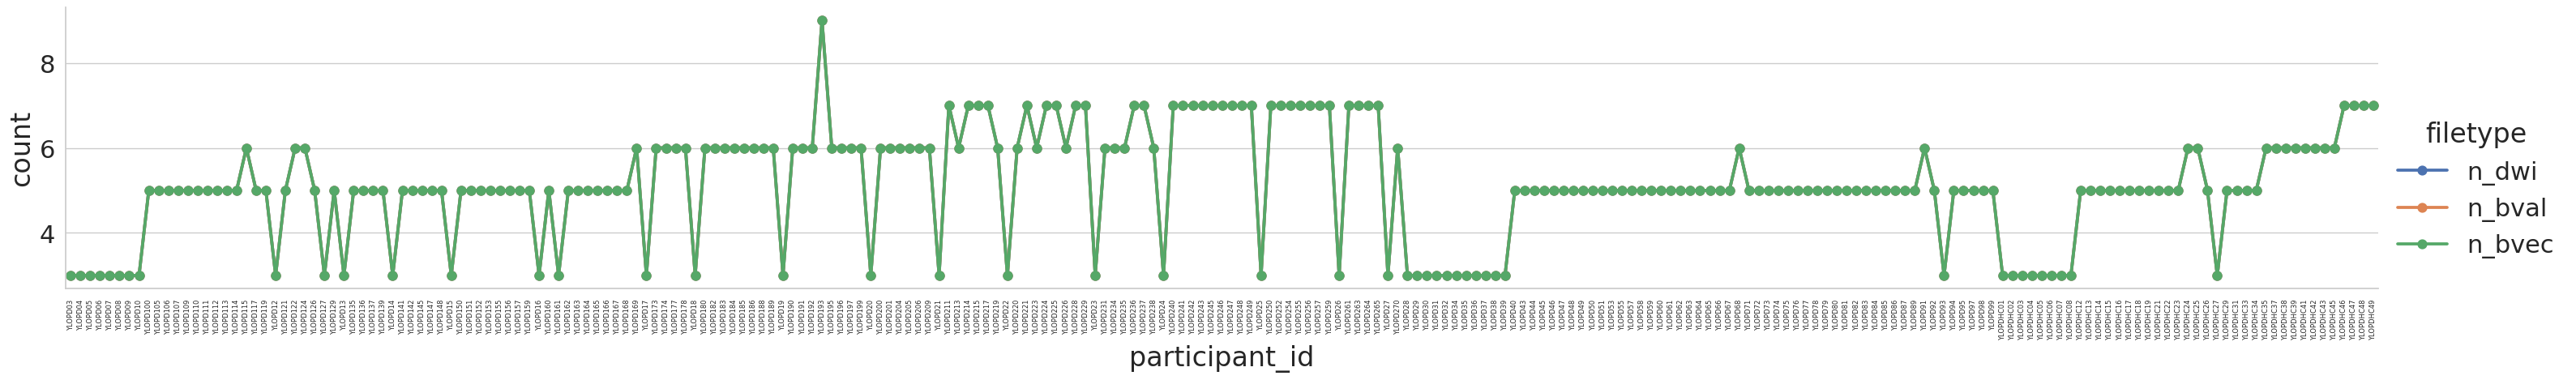

In [8]:
plot_df = dwi_file_count_df.melt(
    id_vars=["participant_id","session","run_id_to_use","run_filename_to_use"],
    var_name="filetype", 
    value_name="count")

sns.set(font_scale=2)
plot_kind = "point" # "violin", "boxen", "point", "bar", or “strip”
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="participant_id", y="count", hue="filetype", kind="point", data=plot_df, aspect=6)
    g.tick_params(axis='x', rotation=90, labelsize=6)



In [9]:
dwi_file_count_df.groupby(["n_dwi"]).count()

,participant_id,session,n_bval,n_bvec,run_id_to_use,run_filename_to_use
n_dwi,,,,,,
3,47,47,47,47,47,47
5,103,103,103,103,103,103
6,51,51,51,51,51,51
7,35,35,35,35,35,35
9,1,1,1,1,1,1


In [10]:
dwi_file_count_df[dwi_file_count_df["n_bval"]==9]

,participant_id,session,n_dwi,n_bval,n_bvec,run_id_to_use,run_filename_to_use
77,YLOPD193,01,9,9,9,1,sub-YLOPD193_ses-01_dir-AP_run-1_dwi.bval
